# ODT - pipeline simulations

This code simulates a whole ODT pipeline to demonstrate projection acquisition to phase unwrapping and reconstruction algorithms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
import ctypes

sys.path.append(os.path.abspath("..")) 
from src.simulating_shapes.cylinder_phase import cylinder_phase_perp_to_z_3d
from src.phase_unwrapping_methods.Ghilia.Ghilia import unwrap_phase_weighted
from src.phase_unwrapping_methods.Ghilia.reliability import reliability_weight_map
from src.helpers.noise import additive_noise
from skimage.restoration import unwrap_phase
from sklearn.metrics import root_mean_squared_error
from src.helpers.rmse import evaluate_phase

# Fix dtype compatibility (needed for Kamui)

if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"): np.int_ = np.int64
if not hasattr(np, "bool_"): np.bool_ = bool

from kamui import unwrap_dimensional 
from scipy.fftpack import dctn, idctn

# -------------------------------------------------------------------
# Load the OpenMP .so you compiled
# -------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "32"  # Adjust based on your CPU
lib = ctypes.cdll.LoadLibrary("../src/phase_unwrapping_methods/ARM_parallel/code/libarm_openmp.so")

# Define the signature of unwrap_phase_ARM
lib.unwrap_phase_ARM.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # wrapped
    ctypes.POINTER(ctypes.c_double),  # unwrapped
    ctypes.POINTER(ctypes.c_double),  # mask
    ctypes.POINTER(ctypes.c_double),  # iW
    ctypes.POINTER(ctypes.c_double),  # jW
    ctypes.c_int, ctypes.c_int,       # rows, cols
    ctypes.c_double, ctypes.c_double, # mu, lambda
    ctypes.c_int, ctypes.c_int        # numIter, ban_OmegaInit
]
lib.unwrap_phase_ARM.restype = None

# -------------------------------------------------------------------
# ARM unwrap helper
# -------------------------------------------------------------------
def arm_unwrap(arr, mu=1.0, lam=0.01, iters=100000,omega_init=1):
    H, W = arr.shape
    arr = np.ascontiguousarray(arr, dtype=np.float64)

    mask = np.ones_like(arr, dtype=np.float64)
    iW   = np.ones_like(arr, dtype=np.float64)
    jW   = np.ones_like(arr, dtype=np.float64)
    out  = np.zeros_like(arr, dtype=np.float64)

    lib.unwrap_phase_ARM(
        arr.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        out.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        mask.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        iW.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        jW.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        H, W,
        mu, lam, iters, omega_init
    )
    return out

# Optics
lam   = 0.532     # wavelength (µm)

PyMaxflow not found, some functions will not be available.


We now generate the shape that we would like to explore. We would start with a 3D elipsoide

In [24]:
n_obj = 1.38                                # Refractive index of the object
n_med = 1.33                                # Refractive index of the medium
nproj = 128                                 # Number of projections
L = 10e-3                                   # 10 mm object field of view
N = 250                                     # number of pixels of the object
a = 2.5e-3
b = 3e-3  
c = 4.5e-3                                  # axes of the elliptical cylinder
height = 5e-3                               # cylinder height along z
rho = 1000                         # contrast
wavelength = 532e-9                         # Wavelength [m]

#--------------------------------------------------
# Grid - real coordinates and fourier space
#--------------------------------------------------

deltax = L/N
x = deltax * np.linspace(-N/2, (N/2)-1, N)
y = x.copy()
z = np.linspace(-height/2, height/2, N)
fx=np.linspace(-1/2/deltax, 1/2/deltax-1/L, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
Fx, Fy, Fz = np.meshgrid(fx, fx, fx, indexing='ij')

# --------------------------------------------------
# 3D Object: finite elipsoide and its FT
# --------------------------------------------------
mask = ((X/a)**2 + (Y/b)**2  + (Z/c) ** 2 <= 1) 
object3D = rho * mask.astype(float)

object3DFT = np.zeros((N, N, N), dtype=complex)

for i in range(N):
    object3DFT[:, :, i] = np.fft.fftshift(
        np.fft.fft2(np.fft.fftshift(object3D[:, :, i]))
    ) * (deltax**2)


We will now generate the projections with different noise levels

In [25]:
# Dictionary to store projections for each noise level
projections_dict = {}

for noise_std in noise_levels:
    # Generate clean projections
    projections_2D, projections_2D_FT, sinogram3D, angles = create_projections(nproj)
    
    # Wrap clean projections
    wrapped_clean = np.angle(np.exp(1j * projections_2D))
    
    # Add noise to the wrapped phase
    noisy_wrapped_projections_2D = wrapped_clean + additive_noise(np.zeros_like(wrapped_clean), noise_std, enabled=True)
    
    # Ensure it stays within [-π, π]
    noisy_wrapped_projections_2D = np.angle(np.exp(1j * noisy_wrapped_projections_2D))
    
    # Save in dictionary
    projections_dict[noise_std] = {
        "wrapped_projections_2D": noisy_wrapped_projections_2D,
        "angles": angles,
        "clean_wrapped_projections_2D": wrapped_clean,  # for ground truth comparisons
    }


Now that we generated the "raw data" we can start full reconstruction. We will begin by demonstarting phase unwrapping algorithms

KeyError: 'noisy_projections_2D'

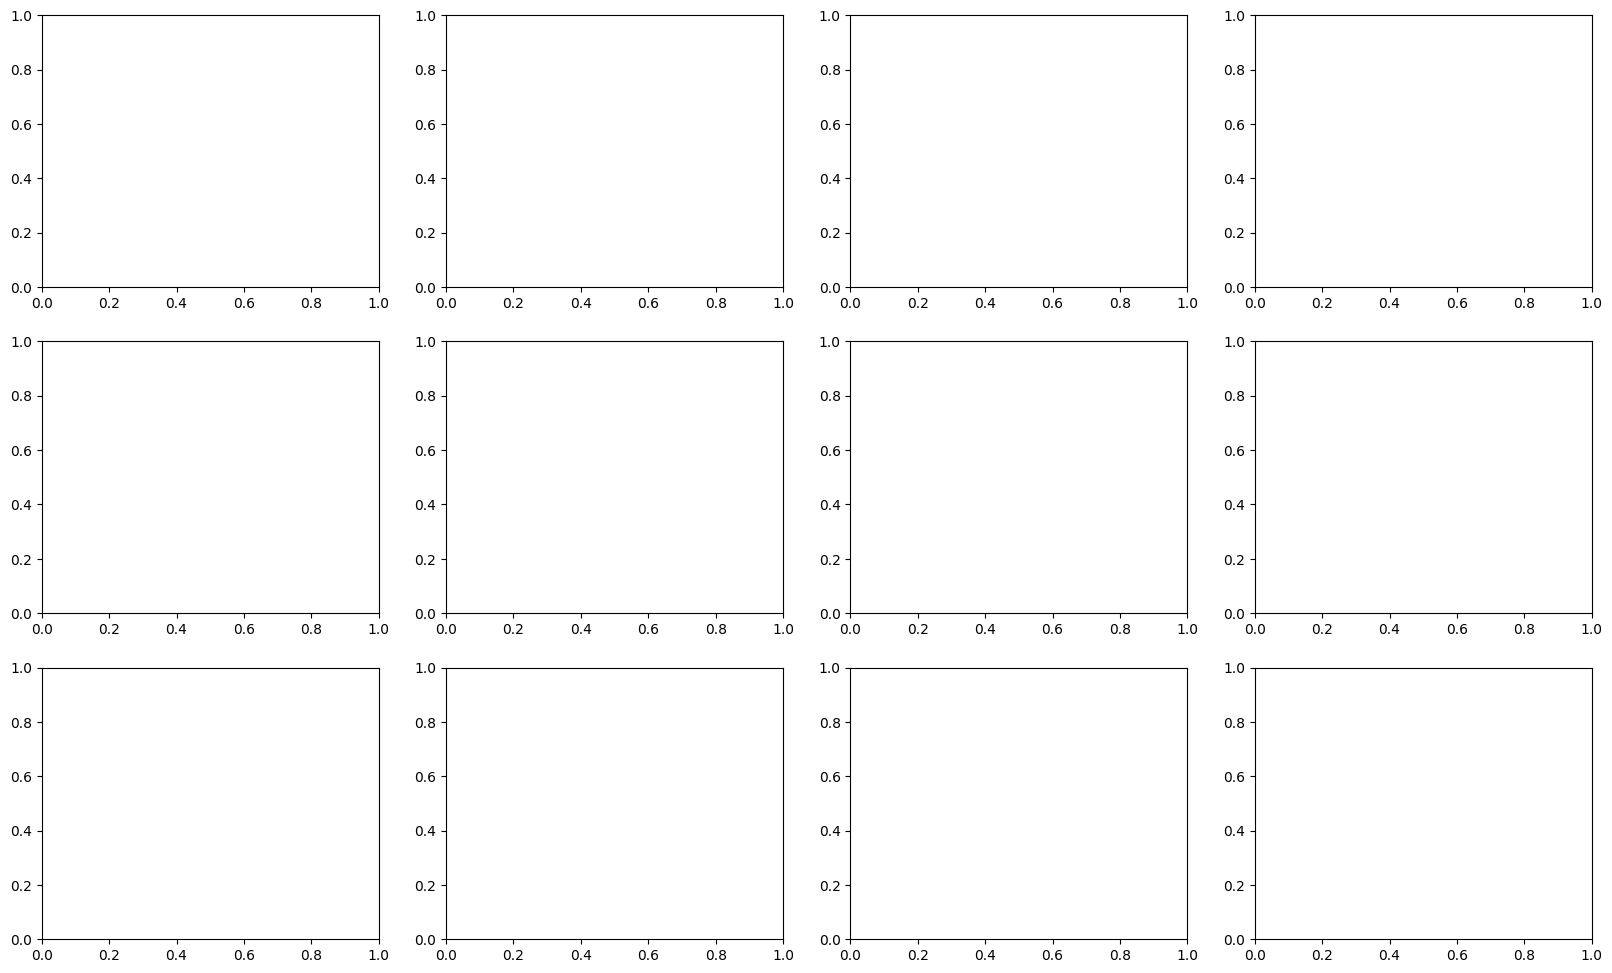

In [26]:
# Dictionary to store unwrapped projections by noise and angle
unwrapped_projections_dict = {}

# Select a few projections to visualize (indices)
visualize_indices = [0, nproj//4, nproj//2, 3*nproj//4]

# Unwrap projections and store keyed by noise level and angle
for noise_std, data in projections_dict.items():
    wrapped_projections_2D = data["wrapped_projections_2D"]
    angles = data["angles"]
    
    for proj_idx, angle in enumerate(angles):
        # Unwrap the projection
        unwrapped_proj = unwrap_dimensional(wrapped_projections_2D[proj_idx])
        
        # Store keyed by noise level and angle
        unwrapped_projections_dict[(noise_std, angle)] = unwrapped_proj

# Visualization: show selected projections across all noise levels
for proj_idx in visualize_indices:
    angle = angles[proj_idx]  # angle of this projection
    n_noise = len(noise_levels)
    
    fig, axs = plt.subplots(3, n_noise, figsize=(5*n_noise, 12))
    
    # Loop over noise levels
    for i, noise_std in enumerate(noise_levels):
        # Ground truth
        gt_proj = projections_dict[0]["noisy_projections_2D"][proj_idx]  # noise=0 as ground truth
        im0 = axs[0, i].imshow(gt_proj, cmap='jet', extent=[z[0]*1e3, z[-1]*1e3, y[0]*1e3, y[-1]*1e3])
        axs[0, i].set_title(f"GT | Noise={noise_std:.2e}")
        axs[0, i].set_xlabel("z (mm)")
        axs[0, i].set_ylabel("y (mm)")
        fig.colorbar(im0, ax=axs[0, i], fraction=0.046, pad=0.04)
        
        # Unwrapped projection
        unwrapped_proj = unwrapped_projections_dict[(noise_std, angle)]
        im1 = axs[1, i].imshow(unwrapped_proj, cmap='jet', extent=[z[0]*1e3, z[-1]*1e3, y[0]*1e3, y[-1]*1e3])
        axs[1, i].set_title(f"Unwrapped | Noise={noise_std:.2e}")
        axs[1, i].set_xlabel("z (mm)")
        axs[1, i].set_ylabel("y (mm)")
        fig.colorbar(im1, ax=axs[1, i], fraction=0.046, pad=0.04)
        
        # Error (unwrapped - ground truth)
        error_proj = unwrapped_proj - gt_proj
        im2 = axs[2, i].imshow(error_proj, cmap='bwr', 
                               vmin=-np.max(np.abs(error_proj)), vmax=np.max(np.abs(error_proj)),
                               extent=[z[0]*1e3, z[-1]*1e3, y[0]*1e3, y[-1]*1e3])
        axs[2, i].set_title(f"Error | Noise={noise_std:.2e}")
        axs[2, i].set_xlabel("z (mm)")
        axs[2, i].set_ylabel("y (mm)")
        fig.colorbar(im2, ax=axs[2, i], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Projection Comparison | Angle = {angle:.1f}°", fontsize=16)
    plt.tight_layout()
    plt.show()
